In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [46]:
def thres_img(img, thres=(0, 0, 0)):
    binary_img = np.zeros_like(img[:, :, 0])
    threshold = (img[:, :, 0] > thres[0]) & (img[:, :, 1] > thres[1]) & (img[:, :, 2] > thres[2])
    binary_img[threshold] = 1
    return binary_img

def warp_img(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def rover_coords(binary_img):
    ypos, xpos = binary_img.nonzero()
    
    xpix = np.absolute(ypos - binary_img.shape[0]).astype(np.float)
    ypix = -(xpos - binary_img.shape[0]).astype(np.float)
    return xpix, ypix

def rotate_pix(xpix, ypix, yaw):
    yaw_rad = yaw * np.pi/180
    xpix = xpix * np.cos(yaw_rad) - ypix * np.sin(yaw_rad)
    ypix = xpix * np.sin(yaw_rad) + ypix * np.cos(yaw_rad)
    return xpix, ypix

def translate_pix(xrot, yrot, xpos, ypos, scale):
    x_pix_world = xpos + (xrot / scale)
    y_pix_world = ypos + (yrot / scale)
    return x_pix_world, y_pix_world

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world
    

(150, -150)

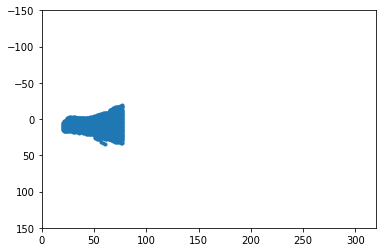

In [47]:
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
bottom_offset = 6

src = np.float32([[14, 140], [300, 140], [120, 95], [200,95]])
dst = np.float32([[145, 140], [155, 140], [145, 130], [155, 130]])
image = mpimg.imread("sample.jpg")
binary_img = thres_img(image, thres=(180, 180, 180))
warped = warp_img(binary_img, src, dst)
xpix, ypix = rover_coords(warped)
plt.plot(xpix, ypix, '.')
plt.xlim(0, 320)
plt.ylim(150, -150)

Xpos = [ 142.50262085] Ypos = [ 116.57449098] Yaw = [ 4.53441538]


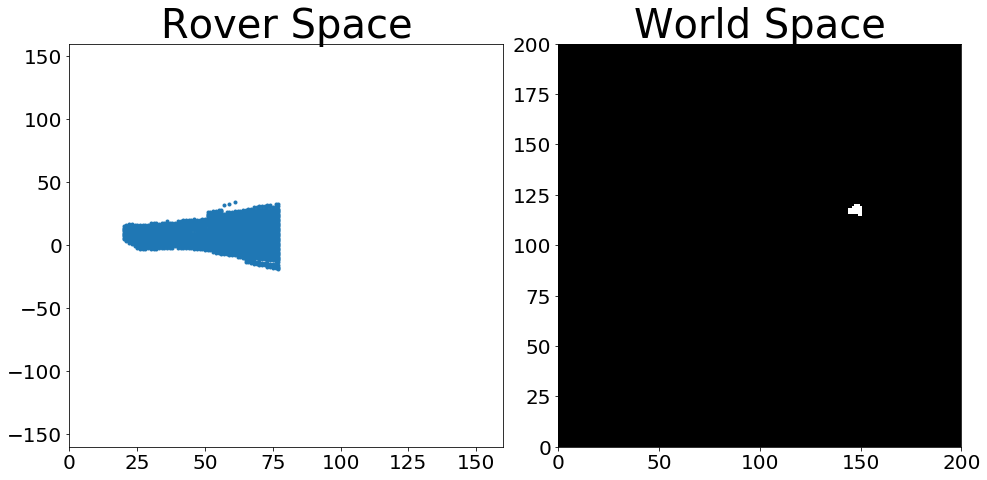

In [50]:
rover_yaw = np.random.random(1)*360

# Generate a random rover position in world coords
# Position values will range from 20 to 180 to 
# avoid the edges in a 200 x 200 pixel world
rover_xpos = np.random.random(1)*160 + 20
rover_ypos = np.random.random(1)*160 + 20

world_map = np.zeros((200, 200))
scale = 10

x_world, y_world = pix_to_world(xpix, ypix, rover_xpos, rover_ypos, rover_yaw, world_map.shape[0], scale)

world_map[y_world, x_world] += 1
print('Xpos =', rover_xpos, 'Ypos =', rover_ypos, 'Yaw =', rover_yaw)
# Plot the map in rover-centric coords

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
f.tight_layout()
ax1.plot(xpix, ypix, '.')
ax1.set_title('Rover Space', fontsize=40)
ax1.set_ylim(-160, 160)
ax1.set_xlim(0, 160)
ax1.tick_params(labelsize=20)

ax2.imshow(world_map, cmap='gray')
ax2.set_title('World Space', fontsize=40)
ax2.set_ylim(0, 200)
ax2.tick_params(labelsize=20)
ax2.set_xlim(0, 200)


plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
#plt.show() # Uncomment if running on your local machine